# Medical terms relation classifier

# dataset
## Source
- [Figure Eight: Medical Sentence Summary - Medical sentence summary and relation-extraction](https://www.kaggle.com/kmader/figure-eight-medical-sentence-summary)

## about
This dataset contains 3,984 medical sentences extracted from PubMed abstracts and relationships between discrete medical terms were annotated. This dataset focuses primarily on “treat” and “cause” relationships, with 1,043 sentences containing treatment relations and 1,787 containing causal ones.

Human-in-the-loop annotators were given two different terms (such as “Lewy Body Dementia” and “Well-formed Visual Hallucinations”) and were asked to mark the relationship between those terms (in this case “Lewy Body Dementia causes Well-Formed Visual Hallucinations).
## Data reference
- [CrowdTruth Measures for Language Ambiguity](http://ceur-ws.org/Vol-1467/LD4IE2015_Dumitrache.pdf)
- [Achieving expert-level annotation quality with crowdtruth](https://pdfs.semanticscholar.org/f760/1751415836c59b0cf4d08df0945bcc8bf4ab.pdf)
- [CrowdTruth ground truth for medical relation extraction (github)](https://github.com/CrowdTruth/Medical-Relation-Extraction/)

# Plan of the project
We will use transfer learning strategy for the project. The retionale behind this idea came out of the fact that 2,830 sentences are quite not enough to build the deep learning model with high accuracy.

The first base model we will use is `AWD-LSTM/QRNN` model trained with `Wikitext 103` dataset.
- [data reference](https://arxiv.org/abs/1609.07843)
- [AWD-LSTM/QRNN](https://arxiv.org/abs/1708.02182)

Secondly, we will train our `Figure Eight` language model with transfer learning method from the `AWD-LSTM/QRNN` model.\
The final deep learning model which does the job we are interested in will be the tranfer-learned model from the `Figure Eight` language model.

(Put a intuitive figure here about the plan)

# Data exploration
From the given research papers, this dataset represents twelve  relations in medical sentences:
![set_of_medical_relation](./figures/set_of_medical_relations.png)

## Importing libraries

In [1]:
import os
import re
import pathlib

import pandas as pd
import torch
from fastai.text import *
from fastai.callbacks.tracker import EarlyStoppingCallback

## Importing train dataset

In [2]:
cwd = pathlib.Path.cwd()
path = cwd/'data'

train = pd.read_csv(path/'train.csv')

## Data inspection

Dataset has a 25 columns with following names.

In [3]:
columns = list(train.columns)
print(f'length of columns: {len(columns)}')
print(f'column names:\n{columns}')

length of columns: 25
column names:
['_unit_id', '_created_at', '_canary', '_id', '_started_at', '_channel', '_trust', '_worker_id', '_country', '_region', '_city', '_ip', 'direction', 'b1', 'b2', 'direction_gold', 'e1', 'e2', 'relation', 'relex_relcos', 'sent_id', 'sentence', 'term1', 'term2', 'twrex']


Here are the 10 head samples of the dataset. Dataframe is transposed to see all the column values for the convenience.

In [4]:
train.head(10).T

,0,1,2,3,4,5,6,7,8,9
_unit_id,502808352,502808352,502808352,502808352,502808352,502808352,502808352,502808354,502808354,502808354
_created_at,7/13/2014 13:48:35,7/13/2014 13:51:12,7/13/2014 16:24:57,7/13/2014 16:33:49,7/13/2014 16:47:27,7/13/2014 16:56:13,7/13/2014 17:14:41,7/13/2014 13:45:15,7/13/2014 13:50:45,7/13/2014 14:07:58
_canary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_id,1321892767,1321894040,1321961909,1321965723,1321970904,1321973849,1321979856,1321891302,1321893871,1321902037
_started_at,7/13/2014 13:48:14,7/13/2014 13:51:07,7/13/2014 16:24:35,7/13/2014 16:33:31,7/13/2014 16:47:06,7/13/2014 16:55:37,7/13/2014 17:14:06,7/13/2014 13:44:25,7/13/2014 13:50:40,7/13/2014 14:07:28
_channel,clixsense,neodev,instagc,elite,neodev,clixsense,prodege,clixsense,neodev,prodege
_trust,0.9167,0.8333,0.6639,0.3923,0.6552,0.6639,0.6151,0.9167,0.8333,0.9444
_worker_id,27871219,17610000,25990856,28276268,27597779,28037714,2422962,27871219,17610000,23977248
_country,NLD,GBR,USA,USA,CAN,GBR,USA,NLD,GBR,GBR
_region,07,I2,NV,CA,AB,I4,IA,07,I2,B5


### Column explanation from the document:
* **SID**: unique ID of the sentence and term pair
* **relation**: medical relation
* **sentence**: medical sentence
* **term1, term**: the 2 medical terms after correction with *FactSpan* and *RelDir*; together, they express the relation: ```term1 cause of/treated by term2```
* **b1, b2**: the beginning position of each term in the sentence, measured in number of characters
* **e1, e2**: the end position of each term in the sentence, measured in number of characters
* **sentence_relation_score**: the sentence relation score of the medical relation; using cosine similarity over the aggregated crowd data, it computes the likelihood that the relation is expressed between the 2 terms in the sentence
* **crowd**: the score used to train the relation extraction classifier by Chang et al.(4) with crowd data; it is the sentence-relation score, with a threshold to select positive and negative examples equal to 0.5, and rescaled in [0.5, 1] for positives, and [-1, -0.5] for negatives.
* **baseline**: discrete (positive or negative) labels are given for each data entry by the distant supervision (1) method, based on whether the relation is expressed between the 2 terms in the sentence
* **expert**: discrete labels based on an expert’s judgment as to whether the *baseline* label is correct
* **test_partition**: manual evaluation scores over the sentences where *crowd* and *expert* disagreed, used for evaluating the classifier; the sentence-relation score threshold was set at 0.7 for maximum agreement; sentences scored with 0 were determined to be unclear and were removed from testing
* **term1_UMLS, term2_UMLS**: the original UMLS (4) terms used for distant supervision, before correction with *FactSpan* and *RelDir*
* **UMLS_seed_relation**: the UMLS relation used as a seed in distant supervision to find the given entry

There are some differences in the columns stated in the document and our dataset, but it seems enough for data analysis.

## Column selection
We will use these columns to train our classifier:
- direction
- relation
- relex_relcos
- sentence
- term1
- term2

### relex_relcos
We could find some hints about what it means from the research papers mentioned earlier. The annotation process is named as `RelEx`(Relation Extraction task) in the research papers. And based on the `RelEx` task, sentence-annotaion score is calculated:

> sentence-annotation score: A core CrowdTruth concept, this metric computes annotation ambiguity in a sentence with the use of `cosine similarity`. In the case of RelEx, it becomes the `sentence-relation score`, and is computed as the cosine similarity between the sentence vector and the unit vector for the relation: srs(s; r) = cos(Vs; ^r). **The higher the value of this metric, the more clearly the relation is expressed in the sentence.** (Dumitrache, A., Aroyo, L., & Welty, C. (2015). Achieving expert-level annotation quality with crowdtruth. In Proc. of BDM2I Workshop, ISWC.)

Thus, we concluded that relex_relcos stands for **REL**ation **EX**traction task - **REL**ation **COS**ine similarity.

## Inputs and outputs
- Input: the medical sentences
- Output: relation between the terms.

If we successfully create the classification model for the relation, we will improve our model to predict direction between terms in the sentences as well.

---

# Data preprocessing
## 1. Dropping unnecessary columns.

In [5]:
drop = ['_unit_id', '_created_at', '_canary', '_id', '_started_at', '_channel', '_trust', '_worker_id', 
        '_country', '_region', '_city', '_ip', 'b1', 'b2', 'direction_gold', 'e1', 'e2', 
        'sent_id', 'twrex']

train.drop(drop, axis=1, inplace=True)

In [6]:
test = pd.read_csv("data/test.csv")
test.drop(drop, axis=1, inplace=True)

validation = pd.read_csv("data/validation.csv")
validation.drop(drop, axis=1, inplace=True)

In [7]:
train.head().T

,0,1,2,3,4
direction,IM CEFTRIAXONE treats URETHRAL OR RECTAL GONOR...,URETHRAL OR RECTAL GONORRHEA treats IM CEFTRIA...,IM CEFTRIAXONE treats URETHRAL OR RECTAL GONOR...,URETHRAL OR RECTAL GONORRHEA treats IM CEFTRIA...,IM CEFTRIAXONE treats URETHRAL OR RECTAL GONOR...
relation,treats,treats,treats,treats,treats
relex_relcos,1,1,1,1,1
sentence,"For treatment of uncomplicated cervical, URETH...","For treatment of uncomplicated cervical, URETH...","For treatment of uncomplicated cervical, URETH...","For treatment of uncomplicated cervical, URETH...","For treatment of uncomplicated cervical, URETH..."
term1,URETHRAL OR RECTAL GONORRHEA,URETHRAL OR RECTAL GONORRHEA,URETHRAL OR RECTAL GONORRHEA,URETHRAL OR RECTAL GONORRHEA,URETHRAL OR RECTAL GONORRHEA
term2,IM CEFTRIAXONE,IM CEFTRIAXONE,IM CEFTRIAXONE,IM CEFTRIAXONE,IM CEFTRIAXONE


In [8]:
test.head().T

,0,1,2,3,4
direction,LIVER location HEPATOCELLULAR CARCINOMA,LIVER location HEPATOCELLULAR CARCINOMA,HEPATOCELLULAR CARCINOMA location LIVER,HEPATOCELLULAR CARCINOMA location LIVER,no_relation
relation,location,location,location,location,location
relex_relcos,0.353553,0.353553,0.353553,0.353553,0.353553
sentence,"Therefore, although serum P III P can be a use...","Therefore, although serum P III P can be a use...","Therefore, although serum P III P can be a use...","Therefore, although serum P III P can be a use...","Therefore, although serum P III P can be a use..."
term1,LIVER,LIVER,LIVER,LIVER,LIVER
term2,HEPATOCELLULAR CARCINOMA,HEPATOCELLULAR CARCINOMA,HEPATOCELLULAR CARCINOMA,HEPATOCELLULAR CARCINOMA,HEPATOCELLULAR CARCINOMA


In [9]:
validation.head().T

,0,1,2,3,4
direction,PHEOCHROMOCYTOMA diagnosed by HYPERTENSION,PHEOCHROMOCYTOMA diagnosed by HYPERTENSION,HYPERTENSION diagnosed by PHEOCHROMOCYTOMA,no_relation,PHEOCHROMOCYTOMA diagnosed by HYPERTENSION
relation,diagnosed by,diagnosed by,diagnosed by,diagnosed by,diagnosed by
relex_relcos,0.824163,0.824163,0.824163,0.824163,0.824163
sentence,This case demonstrates a typical presentation ...,This case demonstrates a typical presentation ...,This case demonstrates a typical presentation ...,This case demonstrates a typical presentation ...,This case demonstrates a typical presentation ...
term1,HYPERTENSION,HYPERTENSION,HYPERTENSION,HYPERTENSION,HYPERTENSION
term2,PHEOCHROMOCYTOMA,PHEOCHROMOCYTOMA,PHEOCHROMOCYTOMA,PHEOCHROMOCYTOMA,PHEOCHROMOCYTOMA


## 2. Defect detection in each column

### Shape of the dataset

In [10]:
print(f'train data shape: {train.shape}')
print(f'validation data shape: {validation.shape}')
print(f'test data shape: {test.shape}')

train data shape: (13340, 6)
validation data shape: (4270, 6)
test data shape: (4566, 6)


### Types of the dataset

In [11]:
print(f'train dtype:\n{train.dtypes}\n-----')
print(f'validation dtype:\n{validation.dtypes}\n-----')
print(f'test dtype:\n{test.dtypes}\n-----')

train dtype:
direction        object
relation         object
relex_relcos    float64
sentence         object
term1            object
term2            object
dtype: object
-----
validation dtype:
direction        object
relation         object
relex_relcos    float64
sentence         object
term1            object
term2            object
dtype: object
-----
test dtype:
direction        object
relation         object
relex_relcos    float64
sentence         object
term1            object
term2            object
dtype: object
-----


### Null value check

In [12]:
train['direction'].isna().sum()

0

In [13]:
validation['direction'].isna().sum()

0

In [14]:
test['direction'].isna().sum()

0

### Duplicate value check

It is normal to have much less unique values in `direction`, and `sentece` column because more then one annotator labeled relationship of two term in a sentence.

In [15]:
print(f"Number of unique values of direction column in train: {len(train['direction'].unique())}")
print(f"Number of unique values of direction column in validation: {len(validation['direction'].unique())}")
print(f"Number of unique values of direction column in test: {len(test['direction'].unique())}")

Number of unique values of direction column in train: 2349
Number of unique values of direction column in validation: 847
Number of unique values of direction column in test: 862


In [16]:
print(f"Number of unique values of sentence column in train: {len(train['sentence'].unique())}")
print(f"Number of unique values of sentence column in validation: {len(validation['sentence'].unique())}")
print(f"Number of unique values of sentence column in test: {len(test['sentence'].unique())}")

Number of unique values of sentence column in train: 1618
Number of unique values of sentence column in validation: 584
Number of unique values of sentence column in test: 590


In [17]:
print(f"Number of unique values of term1 column in train: {len(train['term1'].unique())}")
print(f"Number of unique values of term1 column in validation: {len(validation['term1'].unique())}")
print(f"Number of unique values of term1 column in test: {len(test['term1'].unique())}")

Number of unique values of term1 column in train: 1056
Number of unique values of term1 column in validation: 465
Number of unique values of term1 column in test: 458


In [18]:
print(f"Number of unique values of term2 column in train: {len(train['term2'].unique())}")
print(f"Number of unique values of term2 column in validation: {len(validation['term2'].unique())}")
print(f"Number of unique values of term2 column in test: {len(test['term2'].unique())}")

Number of unique values of term2 column in train: 1216
Number of unique values of term2 column in validation: 494
Number of unique values of term2 column in test: 504


### Ambiguity check

There are some columns whose names are ambiguous to distinguish.

In [19]:
print(f"Unique values of relation column in train:\n{list(train['relation'].unique())}\n-----")
print(f"Unique values of relation column in validation:\n{list(validation['relation'].unique())}\n-----")
print(f"Unique values of relation column in test:\n{list(test['relation'].unique())}\n-----")

Unique values of relation column in train:
['treats', 'diagnosed by', 'contraindicates', 'causes', 'location', 'is location of', 'location of', 'is diagnosed by', 'diagnose_by_test_or_drug']
-----
Unique values of relation column in validation:
['diagnosed by', 'causes', 'treats', 'is location of', 'contraindicates', 'location of', 'is diagnosed by', 'diagnose_by_test_or_drug']
-----
Unique values of relation column in test:
['location', 'diagnosed by', 'causes', 'treats', 'is location of', 'contraindicates', 'is diagnosed by']
-----


Again, from the research papers, it is stated that there are 12 relationships in the dataset: 

> treat, prevent, diagnosis, cause, location, symptom, minifestation, contraindicate, associated with, side effect, is a, part of

And we have two sets of relationships which have ambiguity:\
{'diagnosed by', 'is diagnosed by', 'diagnose_by_test_or_drug'}, and {'location', 'location of', 'is location of'}

### {'diagnosed by', 'is diagnosed by', 'diagnose_by_test_or_drug'}

In [20]:
diagnosed_by = train.loc[train['relation'] == 'diagnosed by']
is_diagnosed_by = train.loc[train['relation'] == 'is diagnosed by']
by_test_or_drug = train.loc[train['relation'] == 'diagnose_by_test_or_drug']

In [21]:
pd.options.display.max_colwidth = 300

In [22]:
diagnosed_by.sample(5)

,direction,relation,relex_relcos,sentence,term1,term2
761,VASOVAGAL SYNCOPE diagnosed by ISOPROTERENOL TEST,diagnosed by,0.956183,Thus the nitroglycerin test seems to be a useful alternative tool for diagnosis of VASOVAGAL SYNCOPE; it is equally specific but more sensitive and feasible than the ISOPROTERENOL TEST.,VASOVAGAL SYNCOPE,ISOPROTERENOL TEST
1132,ALLERGIC CONTACT DERMATITIS diagnosed by HYPERSENSITIVITY,diagnosed by,0.549442,"a Patch testing (e.g., 1% bacitracin in petrolatum) may be useful in diagnosing suspected ALLERGIC CONTACT DERMATITIS when HYPERSENSITIVITY to other topical antibiotics (e.g., neomycin) is suspected.",ALLERGIC CONTACT DERMATITIS,HYPERSENSITIVITY
111,MYASTHENIA GRAVIS diagnosed by INTRAVENOUS EDROPHONIUM CHLORIDE,diagnosed by,1.000000,Maximum velocity and amplitude of repetitive ( 1 per second) 30 degrees saccadic eye movements were quantitatively assessed for 4 minutes before and after INTRAVENOUS EDROPHONIUM CHLORIDE as a diagnostic test for MYASTHENIA GRAVIS,MYASTHENIA GRAVIS,INTRAVENOUS EDROPHONIUM CHLORIDE
1412,PPD SKIN TEST diagnosed by TUBERCULOSIS,diagnosed by,0.936329,"Lower fracture risk by arranging for home safety assessment and devices to improve gait stability, and by recommending tai chi or other balance exercises Arrange periodic ophthalmologic screening for cataracts (posterior subcapsular) and glaucoma to detect vision loss Anticipate reactivation of ...",TUBERCULOSIS,PPD SKIN TEST
849,MICROVASCULAR PROLIFERATION diagnosed by GLIOBLASTOMA MULTIFORME,diagnosed by,0.600000,The presence of MICROVASCULAR PROLIFERATION leads to the histological diagnosis of GLIOBLASTOMA MULTIFORME.,MICROVASCULAR PROLIFERATION,GLIOBLASTOMA MULTIFORME


In [23]:
is_diagnosed_by.sample(5)

,direction,relation,relex_relcos,sentence,term1,term2
5584,RADIAL SCARS is diagnosed by MICROCALCIFICATIONS,is diagnosed by,0.392232,Only the presence of MICROCALCIFICATIONS in 11 of those patients helped the authors distinguish carcinoma from RADIAL SCARS,MICROCALCIFICATIONS,RADIAL SCARS
5978,no_relation,is diagnosed by,0.424264,"Ayestaran A, Lopez R, Montoro JB et al. Pharmacokinetics of conventional formulation versus fat emulsion formulation of AMPHOTERICIN B in a group of patients with NEUTROPENIA",NEUTROPENIA,AMPHOTERICIN B
5589,RADIAL SCARS is diagnosed by MICROCALCIFICATIONS,is diagnosed by,0.392232,Only the presence of MICROCALCIFICATIONS in 11 of those patients helped the authors distinguish carcinoma from RADIAL SCARS,MICROCALCIFICATIONS,RADIAL SCARS
6059,ERGONOVINE is diagnosed by VASOSPASTIC ANGINA,is diagnosed by,0.975900,"These results suggest that the two provocative tests for coronary spasm that involve acetylcholine and ERGONOVINE are clinically useful in the diagnosis of VASOSPASTIC ANGINA, but testing with intracoronary ergonovine is needed when a spontaneous focal coronary spasm is relieved by the intracoro...",VASOSPASTIC ANGINA,ERGONOVINE
5981,NEUTROPENIA is diagnosed by AMPHOTERICIN B,is diagnosed by,0.424264,"Ayestaran A, Lopez R, Montoro JB et al. Pharmacokinetics of conventional formulation versus fat emulsion formulation of AMPHOTERICIN B in a group of patients with NEUTROPENIA",NEUTROPENIA,AMPHOTERICIN B


In [24]:
by_test_or_drug.sample(5)

,direction,relation,relex_relcos,sentence,term1,term2
6199,N PURIFIED PROTEIN DERIVATIV diagnose_by_test_or_drug TUBERCULOSIS,diagnose_by_test_or_drug,0.961524,"In contemporary skin tests for TUBERCULOSIS Koch's, or old, tuberculin has been replaced by tuberculiN PURIFIED PROTEIN DERIVATIVe.",TUBERCULOSIS,N PURIFIED PROTEIN DERIVATIV
6194,TUBERCULOSIS diagnose_by_test_or_drug N PURIFIED PROTEIN DERIVATIV,diagnose_by_test_or_drug,0.961524,"In contemporary skin tests for TUBERCULOSIS Koch's, or old, tuberculin has been replaced by tuberculiN PURIFIED PROTEIN DERIVATIVe.",TUBERCULOSIS,N PURIFIED PROTEIN DERIVATIV
6222,DEPRESSION diagnose_by_test_or_drug DEXAMETHASONE,diagnose_by_test_or_drug,0.990148,"The DEXAMETHASONE suppression test for the detection, diagnosis, and managemnt of DEPRESSION",DEPRESSION,DEXAMETHASONE
6195,TUBERCULOSIS diagnose_by_test_or_drug N PURIFIED PROTEIN DERIVATIV,diagnose_by_test_or_drug,0.961524,"In contemporary skin tests for TUBERCULOSIS Koch's, or old, tuberculin has been replaced by tuberculiN PURIFIED PROTEIN DERIVATIVe.",TUBERCULOSIS,N PURIFIED PROTEIN DERIVATIV
6154,TREATMENT OF UNCOMPLICATED URINARY TRACT INFECTION IN THE ELDERLY diagnose_by_test_or_drug CONTROLLED TRIAL OF NORFLOXACIN AND AMOXYCILLIN IN,diagnose_by_test_or_drug,0.486664,"Hill S, Yeates M, Pathy J et al. A CONTROLLED TRIAL OF NORFLOXACIN AND AMOXYCILLIN IN the TREATMENT OF UNCOMPLICATED URINARY TRACT INFECTION IN THE ELDERLY.",TREATMENT OF UNCOMPLICATED URINARY TRACT INFECTION IN THE ELDERLY,CONTROLLED TRIAL OF NORFLOXACIN AND AMOXYCILLIN IN


After looking into some samples of each relation, it seems like all three relations are the same. We need to change it's `relation` column value to `diagnosis`. Thus, change all these values to 'diagnosis':

In [25]:
train.loc[train['relation'] == 'diagnosed by', 'relation'] = 'diagnosis'
train.loc[train['relation'] == 'is diagnosed by', 'relation'] = 'diagnosis'
train.loc[train['relation'] == 'diagnose_by_test_or_drug', 'relation'] = 'diagnosis'

validation.loc[validation['relation'] == 'diagnosed by', 'relation'] = 'diagnosis'
validation.loc[validation['relation'] == 'is diagnosed by', 'relation'] = 'diagnosis'
validation.loc[validation['relation'] == 'diagnose_by_test_or_drug', 'relation'] = 'diagnosis'

test.loc[test['relation'] == 'diagnosed by', 'relation'] = 'diagnosis'
test.loc[test['relation'] == 'is diagnosed by', 'relation'] = 'diagnosis'

Also, we need to change words in the `direction` column as well. E.g. `TREATMENT OF UNCOMPLICATED URINARY TRACT INFECTION IN THE ELDERLY diagnose_by_test_or_drug CONTROLLED TRIAL OF NORFLOXACIN AND AMOXYCILLIN IN`

In [26]:
condition = '(diagnosed by)|(is diagnosed by)|(diagnose by test or drug)'
replace_sub = lambda x: re.sub(condition, 'diagnosis',x)

In [27]:
train.loc[train['relation'] == 'diagnosis', 'direction'] = (
    train.loc[train['relation'] == 'diagnosis', 'direction'].apply(replace_sub))

validation.loc[validation['relation'] == 'diagnosis', 'direction'] = (
    validation.loc[validation['relation'] == 'diagnosis', 'direction'].apply(replace_sub))

test.loc[test['relation'] == 'diagnosis', 'direction'] = (
    test.loc[test['relation'] == 'diagnosis', 'direction'].apply(replace_sub))

### {'location', 'location of', 'is location of'}

The definition of `location` relation is 'body part in which disease of disorder is observed.' E.g. 'leukemia is found in the circulatory system'. So, when looking into the data set, read one of {'location', 'location of', 'is location of'} as 'is found in' helped a lot to understand the `direction`. These three relationship also seemed to fall into `location` relation.

In [28]:
location = train.loc[train['relation'] == 'location']
location_of = train.loc[train['relation'] == 'location of']
is_location_of = train.loc[train['relation'] == 'is location of']

In [29]:
location.sample(5)

,direction,relation,relex_relcos,sentence,term1,term2
52,no_relation,location,0.40452,It is said that the JOINTS of the affected limb by poliomyelitis are protected from the development of OSTEOARTHRITIS,JOINTS,OSTEOARTHRITIS
50,no_relation,location,0.40452,It is said that the JOINTS of the affected limb by poliomyelitis are protected from the development of OSTEOARTHRITIS,JOINTS,OSTEOARTHRITIS
55,no_relation,location,0.40452,It is said that the JOINTS of the affected limb by poliomyelitis are protected from the development of OSTEOARTHRITIS,JOINTS,OSTEOARTHRITIS
49,OSTEOARTHRITIS location JOINTS,location,0.40452,It is said that the JOINTS of the affected limb by poliomyelitis are protected from the development of OSTEOARTHRITIS,JOINTS,OSTEOARTHRITIS
54,OSTEOARTHRITIS location JOINTS,location,0.40452,It is said that the JOINTS of the affected limb by poliomyelitis are protected from the development of OSTEOARTHRITIS,JOINTS,OSTEOARTHRITIS


In [30]:
location_of.sample(5)

,direction,relation,relex_relcos,sentence,term1,term2
5640,BONE MARROW location of CHRONIC EOSINOPHILIC LEUKAEMIA,location of,0.718421,"A diagnosis of CHRONIC EOSINOPHILIC LEUKAEMIA was made on the basis of myeloproliferative involvement of both peripheral blood and BONE MARROW, associated with eosinophilic differentiation and a t(5;12)(q33;p13) translocation",BONE MARROW,CHRONIC EOSINOPHILIC LEUKAEMIA
5652,no_relation,location of,0.718421,"A diagnosis of CHRONIC EOSINOPHILIC LEUKAEMIA was made on the basis of myeloproliferative involvement of both peripheral blood and BONE MARROW, associated with eosinophilic differentiation and a t(5;12)(q33;p13) translocation",BONE MARROW,CHRONIC EOSINOPHILIC LEUKAEMIA
5508,no_relation,location of,0.676123,Many similarities exist between cerebral ischemia and EPILEPSY regarding BRAIN-damaging and auto-protective mechanisms that are activated following the injurious insult,BRAIN,EPILEPSY
5522,EPILEPSY location of BRAIN,location of,0.676123,Many similarities exist between cerebral ischemia and EPILEPSY regarding BRAIN-damaging and auto-protective mechanisms that are activated following the injurious insult,BRAIN,EPILEPSY
5642,no_relation,location of,0.718421,"A diagnosis of CHRONIC EOSINOPHILIC LEUKAEMIA was made on the basis of myeloproliferative involvement of both peripheral blood and BONE MARROW, associated with eosinophilic differentiation and a t(5;12)(q33;p13) translocation",BONE MARROW,CHRONIC EOSINOPHILIC LEUKAEMIA


In [31]:
is_location_of.sample(5)

,direction,relation,relex_relcos,sentence,term1,term2
2304,no_relation,is location of,0.371391,"The clinicopathologic features of intestinal type adenocarcinoma have been well documented in the stomach, and INTESTINAL METAPLASIA and INTESTINAL TYPE ADENOCARCINOMA has also been reported in the gallbladder.",INTESTINAL METAPLASIA,INTESTINAL TYPE ADENOCARCINOMA
1975,SKIN is location of URTICARIA,is location of,0.956183,Repeated exposures over a period of hours induce a state of tolerance in the SKIN so that URTICARIA fails to develop.,SKIN,URTICARIA
1754,LIVER is location of HEPATOCELLULAR NECROSIS,is location of,0.964901,"Furthermore, histological analyses verified significant HEPATOCELLULAR NECROSIS as well as enhanced myeloperoxidase staining in these LIVER specimens.",LIVER,HEPATOCELLULAR NECROSIS
946,ANENCEPHALY is location of BRAIN,is location of,0.750479,Infants with ANENCEPHALY are born without all or most of their BRAIN and die within a few days of life.,BRAIN,ANENCEPHALY
2901,PROSTATES is location of PROSTATIC CARCINOMAS,is location of,0.979958,We investigate the presence of HPV in 60 prostatic benign hyperplasias and in 5 PROSTATIC CARCINOMAS in surgically resected PROSTATES by PCR technique using consensus and type specific primers.,PROSTATES,PROSTATIC CARCINOMAS


Correct `relation` name:

In [32]:
train.loc[train['relation'] == 'location of', 'relation'] = 'location'
train.loc[train['relation'] == 'is location of', 'relation'] = 'location'

validation.loc[validation['relation'] == 'location of', 'relation'] = 'location'
validation.loc[validation['relation'] == 'is location of', 'relation'] = 'location'

test.loc[test['relation'] == 'is location of', 'relation'] = 'location'

Correct `relation` name in the `direction` column as well.

In [33]:
condition = '(location of)|(is location of)'
replace_sub = lambda x: re.sub(condition, 'location',x)

In [34]:
train.loc[train['relation'] == 'location', 'direction'] = (
    train.loc[train['relation'] == 'location', 'direction'].apply(replace_sub))

validation.loc[validation['relation'] == 'location', 'direction'] = (
    validation.loc[validation['relation'] == 'location', 'direction'].apply(replace_sub))

test.loc[test['relation'] == 'location', 'direction'] = (
    test.loc[test['relation'] == 'location', 'direction'].apply(replace_sub))

**We have clean list of relation now**

In [35]:
print(f"Unique values of relation column in train:\n{list(train['relation'].unique())}\n-----")
print(f"Unique values of relation column in validation:\n{list(validation['relation'].unique())}\n-----")
print(f"Unique values of relation column in test:\n{list(test['relation'].unique())}\n-----")

Unique values of relation column in train:
['treats', 'diagnosis', 'contraindicates', 'causes', 'location']
-----
Unique values of relation column in validation:
['diagnosis', 'causes', 'treats', 'location', 'contraindicates']
-----
Unique values of relation column in test:
['location', 'diagnosis', 'causes', 'treats', 'contraindicates']
-----


### Save data for reuse

In [36]:
dest = path/'preprocessed'
if not os.path.exists(dest):
    os.makedirs(dest)

train.to_csv(dest/'train.csv')
test.to_csv(dest/'test.csv')
validation.to_csv(dest/'validation.csv')

---
## 3. Choose best direction
We determined the direction by majority vote of annotators: `term1->relation->term2`, `term2->relation->term1`, or `no_relation`. Therefore, we set mode direction of each sentence as a best direction.

First, we looked into train dataset to decide the best directions.

In [37]:
train.sample(5)

,direction,relation,relex_relcos,sentence,term1,term2
6297,PCD causes SITUS INVERSUS,causes,0.750479,The number of PCD index patients who have SITUS INVERSUS (because of the randomization of left right symmetry) argues that the disease may be more common than previously suspected; this supposition could be verified if a sensitive and easily used screening test were available.,SITUS INVERSUS,PCD
8215,CARDIOMEGALY IN GSD TYPE II causes ORGAN CELLS (EG) HEPATOMEGALY IN HEPATIC FORMS,causes,0.507093,"Organomegaly may reflect a failure in substrate degradation resulting in substrate accumulation within the ORGAN CELLS (EG) HEPATOMEGALY IN HEPATIC FORMS of GSD and many lysosomal storage diseases, CARDIOMEGALY IN GSD TYPE II",ORGAN CELLS (EG) HEPATOMEGALY IN HEPATIC FORMS,CARDIOMEGALY IN GSD TYPE II
897,no_relation,causes,0.904194,Lacunes consist of small vascular lesions with a volume of between 2 and about 30 mm. These lacunar infarctions are determined by an ISCHEMIA caused by obstructive diseases of small terminal VESSELS in the deep areas of the brain.,VESSELS,ISCHEMIA
7792,FIBROMYALGIA causes PAIN,causes,0.924500,The patient complained of long standing aching PAIN in both lower legs which was diagnosed and managed as FIBROMYALGIA,PAIN,FIBROMYALGIA
8086,no_relation,causes,0.781133,"40,41 In GSS, which is transmitted as an autosomal dominant trait, the affected persons develop ATAXIA followed by dementia; patients with FFI are unable to sleep.",ATAXIA,FFI


We create new dataframe with no duplicate senteces. The best relation and it's direction of sentences will be saved in this dataframe and be used in model training.

In [38]:
train_unique = train.drop_duplicates(subset='sentence', ignore_index=True)
train_unique_sentence = list(train_unique['sentence'])
len(train_unique_sentence)

1618

There's 1618 unique sentences in the training data.

In [39]:
def get_ambiguous_sentences(df, unique_sentence):
    ambiguious_sentence = [] # Store index of ambiguous sentences
    for s in unique_sentence:
        rows = df.loc[train['sentence'] == s, 'direction']
        mode = rows.mode()
        if mode.size > 1:
            # print(f'Sentence:\n{s}\n')
            # print(f"Relex_relcos:\n{train.loc[train['sentence'] == s, 'relex_relcos'].values}\n")
            # print(f"Direction frequency:\n{train.loc[train['sentence'] == s, 'direction'].value_counts()}")
            # print('---------------------------------------------------------------')
            ambiguious_sentence.append(s)
    return ambiguious_sentence

In [40]:
train_ambiguious_sentence = get_ambiguous_sentences(train, train_unique_sentence)
len(train_ambiguious_sentence)

101

Among 1618 unique sentences in the training set, we could find 101 sentences with high ambiguity. The definition of ambiguous sentence is the sentence which has more than one most frequent direction and relation annotated.

If a sentence has more than one most frequent direction, we treated as a ambiguous sentence.

One example of a sentence with high ambiguity:

In [41]:
train.loc[train['sentence'] == 'Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION']

,direction,relation,relex_relcos,sentence,term1,term2
126,HYPERTENSION diagnosis SPONTANEOUSLY ELEVATED BP,diagnosis,0.480384,"Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION",SPONTANEOUSLY ELEVATED BP,HYPERTENSION
127,HYPERTENSION diagnosis SPONTANEOUSLY ELEVATED BP,diagnosis,0.480384,"Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION",SPONTANEOUSLY ELEVATED BP,HYPERTENSION
128,HYPERTENSION diagnosis SPONTANEOUSLY ELEVATED BP,diagnosis,0.480384,"Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION",SPONTANEOUSLY ELEVATED BP,HYPERTENSION
129,HYPERTENSION diagnosis SPONTANEOUSLY ELEVATED BP,diagnosis,0.480384,"Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION",SPONTANEOUSLY ELEVATED BP,HYPERTENSION
130,no_relation,diagnosis,0.480384,"Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION",SPONTANEOUSLY ELEVATED BP,HYPERTENSION
131,SPONTANEOUSLY ELEVATED BP diagnosis HYPERTENSION,diagnosis,0.480384,"Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION",SPONTANEOUSLY ELEVATED BP,HYPERTENSION
132,no_relation,diagnosis,0.480384,"Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION",SPONTANEOUSLY ELEVATED BP,HYPERTENSION
238,no_relation,causes,0.640513,"Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION",SPONTANEOUSLY ELEVATED BP,HYPERTENSION
239,SPONTANEOUSLY ELEVATED BP causes HYPERTENSION,causes,0.640513,"Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION",SPONTANEOUSLY ELEVATED BP,HYPERTENSION
240,HYPERTENSION causes SPONTANEOUSLY ELEVATED BP,causes,0.640513,"Taken together, these data suggest that African green monkeys with SPONTANEOUSLY ELEVATED BP may be a useful experimental model for particular types of human HYPERTENSION",SPONTANEOUSLY ELEVATED BP,HYPERTENSION


We decided to remove those 101 sentences because it may cause confusion during the model training as well.

In [42]:
train_unique = train_unique.query(f'sentence not in {train_ambiguious_sentence}').reset_index(drop = True)

In [43]:
len(train_unique)

1517

And we set best direction of sentence by refering mode of each sentence's direction:

In [44]:
train_unique['direction'] = train_unique['sentence'].apply(
    lambda x: train.loc[train['sentence'] == x, 'direction'].mode()[0])

Apply same logic to validation and test data as well.\
Validation data:

In [45]:
validation_unique = validation.drop_duplicates(subset='sentence', ignore_index=True)
validation_unique_sentence = list(validation_unique['sentence'])
len(validation_unique_sentence)

584

In [46]:
validation_ambiguious_sentence = get_ambiguous_sentences(validation, validation_unique_sentence)
len(validation_ambiguious_sentence)

5

In [47]:
validation_unique = validation_unique.query(f'sentence not in {validation_ambiguious_sentence}').reset_index(drop = True)
validation_unique['direction'] = validation_unique['sentence'].apply(
    lambda x: validation.loc[validation['sentence'] == x, 'direction'].mode()[0])

Test data:

In [48]:
test_unique = test.drop_duplicates(subset='sentence', ignore_index=True)
test_unique_sentence = list(test_unique['sentence'])
len(test_unique_sentence)

590

In [49]:
test_ambiguious_sentence = get_ambiguous_sentences(test, test_unique_sentence)
len(test_ambiguious_sentence)

9

In [50]:
test_unique = test_unique.query(f'sentence not in {validation_ambiguious_sentence}').reset_index(drop = True)
test_unique['direction'] = test_unique['sentence'].apply(
    lambda x: test.loc[test['sentence'] == x, 'direction'].mode()[0])

### Save data for reuse

In [51]:
dest = path/'for_training'
if not os.path.exists(dest):
    os.makedirs(dest)

train_unique.to_csv(dest/'train.csv', index=False)
test_unique.to_csv(dest/'test.csv', index=False)
validation_unique.to_csv(dest/'validation.csv', index=False)

## 4. Class distribution check

In [52]:
train_unique.groupby('relation')['sentence'].count()

relation
causes             780
contraindicates      7
diagnosis           55
location            63
treats             612
Name: sentence, dtype: int64

In [53]:
validation_unique.groupby('relation')['sentence'].count()

relation
causes             275
contraindicates      5
diagnosis           28
location            25
treats             246
Name: sentence, dtype: int64

In [54]:
test_unique.groupby('relation')['sentence'].count()

relation
causes             293
contraindicates      4
diagnosis           34
location            32
treats             227
Name: sentence, dtype: int64

## 5. Fix unbalanced data

In [55]:
def downsample(df, n):
    columns = ['causes', 'treats', 'contraindicates']
    causes_downsampled = df.query("relation == 'causes'").sample(n=n, replace=False, random_state=777)
    treats_downsampled = df.query("relation == 'treats'").sample(n=n, replace=False, random_state=777)
    other = df.query(f"relation not in {columns}")
    return pd.concat([causes_downsampled, treats_downsampled, other])

In [56]:
train_downsampled = downsample(train_unique, 60)
validation_downsampled = downsample(validation_unique, 30)
test_downsampled = downsample(test_unique, 30)

In [57]:
train_downsampled.groupby('relation')['sentence'].count()

relation
causes       60
diagnosis    55
location     63
treats       60
Name: sentence, dtype: int64

In [58]:
validation_downsampled.groupby('relation')['sentence'].count()

relation
causes       30
diagnosis    28
location     25
treats       30
Name: sentence, dtype: int64

In [59]:
test_downsampled.groupby('relation')['sentence'].count()

relation
causes       30
diagnosis    34
location     32
treats       30
Name: sentence, dtype: int64

### Save data for training

In [60]:
dest = path/'for_training'
if not os.path.exists(dest):
    os.makedirs(dest)

train_downsampled.to_csv(dest/'train_downsampled.csv', index=False)
test_downsampled.to_csv(dest/'test_downsampled.csv', index=False)
validation_downsampled.to_csv(dest/'validation_downsampled.csv', index=False)

# Multi-class classification

## Importing data

In [61]:
data_path = path/'for_training'

In [62]:
data = TextLMDataBunch.from_df(path = data_path,
                               train_df=train_unique,
                               valid_df=validation_unique,
                               text_cols = 'sentence',
                               label_cols = 'relation')

In [63]:
data.save()

When we import data using fastai.text.TextDataBunch, it automatically tokenize the sentence.

In [64]:
data.show_batch()

idx,text
0,"neuroblastoma , retinoblastoma , xxup osteosarcoma xxmaj wilms ' tumour , xxup retinoblastoma xxmaj xxunk ' sarcoma , central nervous system ( xxup cns ) tumours and xxunk . xxbos xxmaj acute xxunk state moderate exercise significantly altered circulating ige concentrations in volunteers with known xxup allergy while ige concentrations in xxup non xxup allergy sufferers did not change . xxbos xxup salmeterol prevented xxup exercise xxup induced xxup asthma"
1,"combination for painful knee osteoarthritis xxmaj osteoarthritis and xxmaj cartilage a randomized , placebo controlled , cross over study of xxunk extracts and ibuprofen in osteoarthritis xxmaj rheumatic xxmaj diseases xxmaj xxunk of xxmaj north xxmaj xxunk xxmaj xxunk and rheumatic disease xxmaj rheumatology ( xxmaj xxunk ) a randomized , double blind , placebo controlled trial of xxup glucosamine xxup sulphate as an analgesic in xxup osteoarthritis xxup of"
2,"the xxup bronchial xxup hyperreactivity to xxup methacholine inhalation challenge were observed on the first day of study . xxbos xxmaj on the other hand xxup primary xxup skin xxup diseases such as xxup psoriasis atopic dermatitis , xxunk vulgaris , chronic idiopathic urticaria and alopecia areata may induce xxunk features . xxbos xxmaj we describe a patient with cutaneous xxunk who presented with xxup neurological xxup symptoms due to"
3,"de xxunk appeared xxup hypertension in a young female patient at her xxunk trimester of pregnancy . xxbos xxmaj phase xxup iii study of concurrent xxunk with cisplatin , vinblastine , dacarbazine , interleukin 2 , and interferon alfa 2b versus cisplatin , vinblastine , and xxup dacarbazine alone in patients with xxup metastatic xxup malignant xxup melanoma ( xxunk last modified 10 / xxunk . xxbos xxmaj when xxunk"
4,) can be given to xxunk to control xxup inflammation in patients who develop severe renal disease . xxbos xxmaj studies have shown that xxup subcutaneous xxup xxunk 20 microg / day is effective in women with xxup postmenopausal xxup osteoporosis men with idiopathic or xxunk osteoporosis and patients with glucocorticoid induced osteoporosis . xxbos xxup mastocytosis is a heterogeneous group of disorders characterized by mast cell xxup hyperplasia xxup


As you see they use special tokens.

The rules are all listed below, here is the meaning of the special tokens:
- UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)
- PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch
- BOS (xxbos) represents the beginning of a text in your dataset
- FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
- TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
- TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
- TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
- TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

Refer [here](https://docs.fast.ai/text.transform.html#Tokenizer) for more information.

In [65]:
print(f'Total number of tokens in a vocabulary: {len(data.vocab.itos)}')
print(f'Sample tokens:\n{data.vocab.itos[:50]}')

Total number of tokens in a vocabulary: 3672
Sample tokens:
['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep', ',', 'of', 'the', 'and', 'in', '.', 'with', 'a', '(', 'to', ')', 'for', 'or', 'is', 'patients', 'by', 'treatment', ':', ']', '[', ';', 'as', 'that', 'be', 'may', 'are', 'disease', 'was', 'pain', 'an', '%', '1', 'syndrome', 'from', 'caused', 'not', 'were', '/', 'on', 'therapy', 'other']


## Train language model with transfer learning based on Wikitext 103 language model

We will use sequence to sequence model consist of awd_lstm layers trained with Wiki103 data as a base model of our classifier. Before we build classifier, we will build language model first to make our model have some sense of the language used in our dataset.

In [66]:
language_model = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

Find good learning rate

In [67]:
language_model.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-01
Min loss divided by 10: 5.25E-02


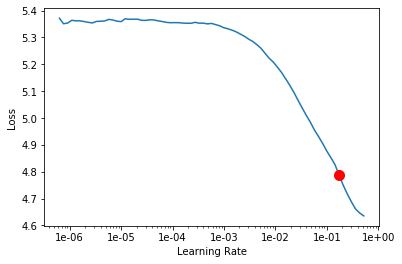

In [68]:
language_model.recorder.plot(skip_end=15, suggestion = True)
min_grad_lr = language_model.recorder.min_grad_lr

In [69]:
language_model.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.183836,4.190846,0.300446,00:02


In [70]:
language_model.unfreeze()
language_model.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.898834,3.719529,0.354643,00:02
1,3.393292,3.274726,0.420491,00:02
2,2.839921,3.301594,0.430223,00:02


To check our language model's performance, we printed out 5 sentences with the input "The evidence for." Though the accuracy is 0.41 and losses are high, it seems our language model works pretty well. We used this way as a heuristic way of assessing the language model's performance.

In [71]:
print("\n\n".join(language_model.predict('if they cause', 100, temperature=1.1) for _ in range(5)))

if they cause [ AMPHOTERICIN b ] , exercise learning to take a follow up of symptoms such as right heart failure or heart failure antidepressants , and evaluation of the dysplastic elevation that prevents the rifapentine extremely still unclear , with no effects on natural approaches . xxbos Unlike REVIEW does not mean that the physician must recommend an oral 146 proteins in fluconazole risks because of the rash of spot or spot INFLAMMATION xxbos We present a patient with a hair who developed a COMPLETELY HYPERSENSITIVITY REACTION characterized by AUTOIMMUNE

if they cause late INTERVAL , synthetic diarrhea , ALLEVIATE RR = [ MEAN INTERVAL ] has been shown to be an effective for subsequent DYSPNEA xxbos TRIAL Treatment of prophylaxis after carbamazepine and therapy with severe NEUTROPENIA xxbos Oral therapy for LISTERIA MONOCYTOGENES may also result with granulomatosis resonance 4 touch a adjacent neurologic suppression to alleviate sleep and sleep ( brown methyldopa process . xxbos K

In [72]:
language_model.save_encoder('fine_tuned_enc')

## Train classifier with transfer learning based on our custom language model's encoder

We checked that our language model works well. From this, we regarded that the encoder of our language model undersands the data and have a sense of the data. So, we used the encoder as base model of our classifier.

In [73]:
data_clas = TextClasDataBunch.from_df(path = data_path, 
                                      train_df=train_downsampled, 
                                      valid_df=validation_downsampled,
                                      test_df=test_downsampled,
                                      text_cols = 'sentence',
                                      label_cols = 'relation',
                                      vocab=data.vocab,
                                      bs = 20)

In [74]:
data_clas.show_batch()

text,target
"xxbos prolonged xxup qt interval , torsades de pointes ) 1 xxmaj concomitant use contraindicated 1 xxmaj digoxin xxmaj increased digoxin plasma concentrations 1 xxmaj if used concomitantly , monitor digoxin plasma concentrations 1 xxmaj ergot alkaloids ( ergotamine , dihydroergotamine ) xxmaj possible pharmacokinetic interaction ( increased plasma concentrations of ergot alkaloids resulting in ergotism ) 1 xxmaj concomitant use contraindicated 1 xxmaj glipizide xxmaj no clinically important pharmacokinetic",treats
"xxbos xxmaj the xxunk points of the xxmaj xxunk consensus are : the usefulness of xxup ct scanning evaluation of adrenal incidentalomas , the systematic screening for pheochromocytoma , the usefulness of the 1 mg overnight xxup dexamethasone test to screen for xxup latent xxup hypercortisolism the xxunk to xxunk mild biological abnormalities of the xxup xxunk axis , the consensus to remove surgically most of tumours greater than 4",diagnosis
xxbos xxmaj affinity xxunk with a xxup xxunk labelled xxunk derivative of xxup tsh ( xxup xxunk xxup tsh ) was used to xxunk xxup tsh receptor size in the following specimens of human thyroid tissue : ( 1 ) xxup cold xxup nodules ; ( 2 ) autonomous nodules ; ( 3 ) papillary carcinoma ; ( 4 ) xxup medullary xxup carcinoma ; ( 5 ) metastasis of,location
"xxbos xxmaj it might take at least 12 days , when the ph of nitrite solution is lowered , for the concentration of xxup no to xxunk a level sufficiently high to activate xxunk xxunk and so it seems xxunk that naturally circulating nitrite is involved in vasodilation in ischemic tissue through its conversion into xxup no . xxmaj it is more xxunk to consider that xxup no is produced",location
"xxbos a case of xxmaj xxunk 's xxup disease ( xxup subacute xxup xxunk xxup xxunk ) is reported with such xxunk features as early onset , xxup dystonia paraparesis the presence of low xxunk areas in both basal ganglias on xxunk tomography of the brain and the presence of a high xxunk intensity in both basal ganglias in xxup xxunk xxunk image by xxup mr . xxmaj the electron",causes


In [75]:
data_clas.save('data_classification.pkl')

In [76]:
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('fine_tuned_enc')
classifier.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-02


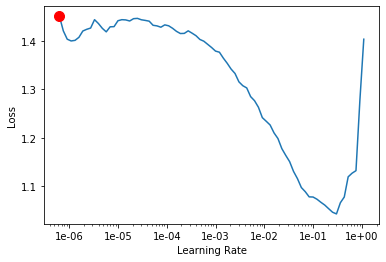

In [77]:
classifier.lr_find()
classifier.recorder.plot(suggestion=True)
min_grad_lr = classifier.recorder.min_grad_lr

In [78]:
classifier.fit_one_cycle(1, 5.25E-03, moms=(0.8,0.7)) # 5.25E-03

epoch,train_loss,valid_loss,accuracy,time
0,1.237406,1.253640,0.504425,00:27


In [79]:
classifier.save('first')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 4.79E-03


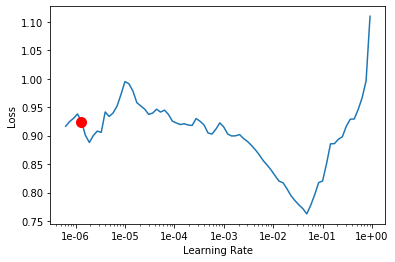

In [80]:
classifier.freeze_to(-2)
classifier.lr_find()
classifier.recorder.plot(suggestion=True)
min_grad_lr = classifier.recorder.min_grad_lr

In [81]:
classifier.fit_one_cycle(1, slice(1.91E-02/(2.6**4),1.91E-02), moms=(0.8,0.7)) # 1.91E-02

epoch,train_loss,valid_loss,accuracy,time
0,1.167647,1.124194,0.513274,00:27


In [82]:
classifier.save('second')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 4.79E-03


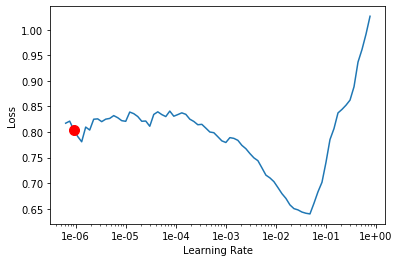

In [83]:
classifier.unfreeze()
classifier.lr_find()
classifier.recorder.plot(suggestion=True)
min_grad_lr = classifier.recorder.min_grad_lr

In [84]:
classifier.fit_one_cycle(5, slice(1.20E-05/(2.6**4),1.20E-05), moms=(0.8,0.7)) # 1.20E-05

epoch,train_loss,valid_loss,accuracy,time
0,0.838693,1.139046,0.522124,00:27
1,0.827389,1.137110,0.530973,00:27
2,0.808984,1.136704,0.539823,00:27
3,0.798182,1.142705,0.557522,00:27
4,0.804010,1.158465,0.530973,00:27
5,0.808594,1.141977,0.566372,00:27
6,0.817680,1.148137,0.522124,00:27
7,0.813212,1.148999,0.557522,00:27
8,0.817033,1.156825,0.539823,00:27
9,0.816996,1.139716,0.548673,00:27


In [85]:
classifier.save('third')

## Model assessment

In [86]:
preds,y,losses = classifier.get_preds(with_loss=True)

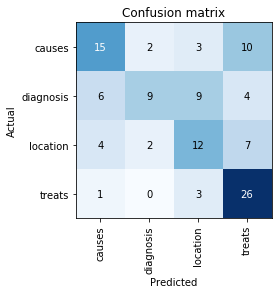

In [87]:
interp = ClassificationInterpretation(classifier, preds, y, losses)
interp.plot_confusion_matrix()

# Binary classification

In [88]:
target = ['causes', 'treats']
train_binary = train_unique.query(f"relation in {target}")
validation_binary = validation_unique.query(f"relation in {target}")
test_binary = test_unique.query(f"relation in {target}")

In [89]:
data_binary = TextClasDataBunch.from_df(path = data_path,
                                        train_df=train_binary,
                                        valid_df=validation_binary,
                                        test_df=test_binary,
                                        text_cols = 'sentence',
                                        label_cols = 'relation',
                                        vocab=data.vocab,
                                        bs = 20)

In [90]:
data_binary.show_batch()

text,target
xxbos severe mental illness ( xxmaj cochrane xxmaj review ) xxmaj risperidone versus other atypical antipsychotic medication for schizophrenia ( xxmaj cochrane xxmaj review ) xxmaj xxunk for schizophrenia ( xxmaj cochrane xxmaj review ) xxmaj xxunk for schizophrenia ( xxmaj cochrane xxmaj review ) xxmaj depot risperidone for xxup schizophrenia ( xxmaj cochrane xxmaj review ) xxup olanzapine for schizophrenia ( xxmaj cochrane xxmaj review ) xxmaj antipsychotic medication,treats
"xxbos xxmaj sulfasalazine for rheumatoid arthritis xxmaj penicillamine for treating rheumatoid arthritis xxmaj moderate term , low dose corticosteroids for rheumatoid arthritis xxmaj xxunk for rheumatoid arthritis : an xxunk of xxmaj cochrane reviews xxmaj low level xxunk therapy ( xxmaj classes i , xxup ii and xxup iii ) for treating rheumatoid arthritis xxup xxunk xxup gold xxup for xxup rheumatoid xxup arthritis xxmaj xxunk therapy for treating rheumatoid",treats
"xxbos xxup alert xxup triggers xxmaj clinical xxmaj xxunk : • xxmaj positive serum and urine human xxunk xxunk ( xxup hcg ) • xxmaj female of childbearing potential , sexually active , on oral isotretinoin or topical tazarotene • xxup severe xxup nodular xxup acne resistant to oral antibiotics • xxmaj mood xxunk or depression • xxmaj doxycycline use in xxunk xxunk , xxunk , or xxunk • xxmaj",treats
"xxbos xxmaj low grade squamous intraepithelial xxup lesion ( xxup xxunk ) ( cellular changes consistent with xxup hpv , mild dysplasia , xxup cin 1 ) xxmaj high grade squamous intraepithelial lesion ( xxup xxunk ) ( moderate to severe xxup dysplasia xxup cin 2 , xxup cin 3 , xxup cis ) ( indicate if there are features xxunk of xxunk ) xxmaj squamous cell carcinoma xxmaj glandular",causes
"xxbos xxmaj oral availability and safety should rapidly make it the preferred agent xxmaj influenza virus vaccine xxmaj induces protective antibodies against influenza 0.5 ml i m xxunk xxmaj prevents influenza , in turn preventing worsened anemia due to infection and complications of xxunk xxmaj fever and sore arm in xxmaj give to all patients with hemolytic anemias xxmaj pneumococcal xxunk vaccine xxmaj develops antibodies to pneumococcal antigens 0.5 ml",causes


In [91]:
data_binary.save('data_binary.pkl')

In [92]:
b_classifier = text_classifier_learner(data_binary, AWD_LSTM, drop_mult=0.5)
b_classifier.load_encoder('fine_tuned_enc')
b_classifier.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 3.63E-02


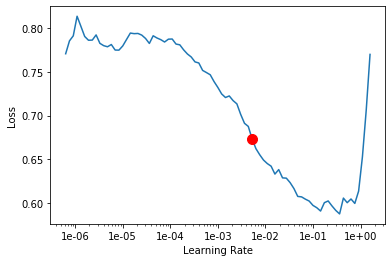

In [93]:
b_classifier.lr_find()
b_classifier.recorder.plot(suggestion=True)
min_grad_lr = b_classifier.recorder.min_grad_lr

In [94]:
b_classifier.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,0.458816,0.420532,0.796545,00:32


In [95]:
b_classifier.save('binary-first')

In [97]:
b_classifier.freeze_to(-2)
b_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.412550,0.391987,0.817658,00:31


In [98]:
b_classifier.save('binary-second')

In [99]:
b_classifier.unfreeze()
b_classifier.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.321296,0.381456,0.848369,00:33
1,0.297446,0.394369,0.846449,00:32


## Model assessment

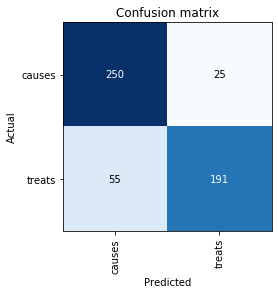

In [101]:
preds,y,losses = b_classifier.get_preds(with_loss=True)
interp = ClassificationInterpretation(b_classifier, preds, y, losses)
interp.plot_confusion_matrix()